In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), "../../"))

In [2]:
import math
import pandas as pd 
import numpy as np
import agreement_utils as calc
from itertools import combinations

from readers.memo_ga import MEMOGroupAff

In [3]:
def zm_labels(labels_df):
    for interaction in np.unique(labels_df["interactionID"].values):
        for annot_col in labels_df.columns:
            if "_00" in annot_col: 
                curr_df = labels_df.loc[labels_df['interactionID'] == interaction, annot_col]
                if not curr_df.isnull().values.any():
                    curr_df = curr_df-round(np.mean(curr_df.values))
                    labels_df.loc[labels_df['interactionID'] == interaction, annot_col] = curr_df
    return labels_df

def load_labels(zm=False):
    memodb = MEMOGroupAff()
    labels_df = pd.read_csv(memodb.joint_labels_df_path)
    if zm:
        labels_df = zm_labels(labels_df)
    return labels_df, memodb.groups, memodb.sessions, memodb.emo_dims, memodb.annotators, memodb

# Parameters

In [4]:
is_zm = False
# cohens kappa parameters
submode_cohen = "quadratic"
# fleiss kappa parameters
submode_fleiss = "unif" # ‘randolph’ or ‘uniform’ (only first 4 letters are needed) 
# pcorrel kappa parameters
# krank correl kappa parameters

In [5]:
labels_df, groups, sessions, emo_dims, annotators, memodb = load_labels(zm=is_zm)
print('Annotators - ', annotators)
print(np.unique(labels_df["interactionID"].values))

Annotators -  ['001', '002', '003', '004', '005', '006', '007', '008']
['10_1' '10_2' '10_3' '11_1' '11_2' '11_3' '12_1' '12_2' '12_3' '13_1'
 '13_2' '13_3' '14_1' '14_2' '14_3' '15_1' '15_2' '15_3' '4_1' '4_2' '4_3'
 '5_1' '5_2' '5_3' '6_1' '6_2' '6_3' '7_1' '7_2' '7_3' '8_1' '8_2' '9_1'
 '9_2' '9_3']


In [6]:
def omit_least_agreement_annot(annot_df, annots, emo_dim):
    df = annot_df.copy()
    final_annots = annots.copy()
    if emo_dim == "arousal":
        df = df.drop(columns=["Arousal_003"])
        final_annots.remove("003")
    elif emo_dim == "valence":
        df = df.drop(columns=["Valence_006"])
        final_annots.remove("006")
    return df, final_annots

def calc_samplewise_agreement_for_MEMO(emodim, mode="mse"):        
    final_labels_df = labels_df
    final_annotators = annotators
        
    print(" Calculating for ", emodim, " annotations ~~~~~~~, for annotators = ",  str(final_annotators))
    req_cols = [i[0]+"_"+i[1] for i in combinations(final_annotators, 2)]
    req_cols.extend(['interactionID', "average_"+mode])

    samplewise_scores = []
    interction_ids = []
    window_ids = []
    groundtruths = []
    for grp in groups:
        for ses in sessions:
            if grp+"_"+ses != "8_3":
                avg_score, pairwise_scores, mean_labels = calc.calc_agreement_for(final_labels_df, group=grp, session=ses, emo_dim=emodim, mode=mode)
                
                samplewise_scores.extend(avg_score.tolist())
                interction_ids.extend(np.repeat("group"+grp+"_session"+ses, avg_score.shape[0]))
                window_ids.extend(np.arange(0, avg_score.shape[0]))
                groundtruths.extend(mean_labels)
                
    return pd.DataFrame(data={'InteractionId': interction_ids, 'WindowId': window_ids, mode: samplewise_scores, emodim: groundtruths})

# Util Fn..,
def calc_agreement_for_MEMO(memodb, mode, submode, best5=False):
    
    for dim in emo_dims:
        if best5:
            final_labels_df, final_annotators = omit_least_agreement_annot(labels_df, annotators, dim)
        else:
            final_labels_df = labels_df
            final_annotators = annotators
        print(" Calculating for ", dim, " annotations ~~~~~~~, for annotators = ",  str(final_annotators))
        req_cols = [i[0]+"_"+i[1] for i in combinations(final_annotators, 2)]
        req_cols.extend(['interactionID', "average_"+mode])
        agreement_df = pd.DataFrame(columns=req_cols)
        overall_score = 0.0
        nonnan_counter = 0
        interaction_scores = {}
        for grp in groups:
            for ses in sessions:
                if grp+"_"+ses != "8_3":
                    avg_score, pairwise_scores = calc.calc_agreement_for(final_labels_df, group=grp, session=ses, emo_dim=dim, mode=mode, submode=submode)
                    interaction_scores = pairwise_scores
                    interaction_scores["interactionID"] = grp+"_"+ses
                    interaction_scores["average_"+mode] = avg_score
                    if not math.isnan(avg_score):
                        overall_score = overall_score + avg_score
                        nonnan_counter = nonnan_counter + 1
                                           
                    agreement_df = agreement_df._append(interaction_scores, ignore_index=True)
        print(agreement_df.columns)
        print(agreement_df.shape)
                   
        final_row = dict.fromkeys(interaction_scores, "")
        final_row['interactionID'] = 'OVERALL '+ mode 
        print("No. of interactions = ", len(agreement_df))
        final_row["average_"+mode] = overall_score/nonnan_counter
        agreement_df = agreement_df._append(final_row, ignore_index=True)
        
        zm_store = "/zm/" if is_zm else ""
        store = memodb.annotator_agreement_folder + mode + zm_store + "/pairwise/" if not best5 else memodb.annotator_agreement_folder + mode + zm_store + "/best5/pairwise/"
        os.makedirs(store, exist_ok = True)

        submode_prefix = "nonwgts" if submode is None else submode        
        fname = submode_prefix + "_"+ dim +".csv" if mode == 'cohen' else mode + "_"+ dim +".csv"
        agreement_df.to_csv(store + fname)

        overall_store = memodb.annotator_agreement_folder + mode + "/" + zm_store + fname if not best5 else memodb.annotator_agreement_folder + mode + zm_store + "/best5/" + fname
        overall_agreement_df =  agreement_df[["interactionID", "average_"+mode]]
        overall_agreement_df.to_csv(overall_store)

    return True   
                  
def calc_fleiss_agreement_for_MEMO(memodb, mode, submode, best5=False):
    
    for dim in emo_dims:
        if best5:
            final_labels_df, final_annotators = omit_least_agreement_annot(labels_df, annotators, dim)
        else:
            final_labels_df = labels_df
            final_annotators = annotators
            
        print(" Calculating for ", dim, " annotations ~~~~~~~, for annotators = ",  str(final_annotators))
        req_cols = ['interactionID', "average_"+mode]
        
        agreement_df = pd.DataFrame(columns=req_cols)
        overall_score = 0.0
        interaction_scores = {}
        for grp in groups:
            for ses in sessions:
                if grp+"_"+ses != "8_3":
                    fleiss_score, _ = calc.calc_agreement_for(final_labels_df, group=grp, session=ses, emo_dim=dim, mode=mode, submode=submode)
                    interaction_scores["interactionID"] = grp+"_"+ses
                    interaction_scores["average_"+mode] = fleiss_score
                    overall_score = overall_score + fleiss_score
                    
                    agreement_df = agreement_df._append(interaction_scores, ignore_index=True)
                        
        final_row = dict.fromkeys(interaction_scores, "")
        final_row['interactionID'] = 'OVERALL '+ mode 
        print("No. of interactions = ", len(agreement_df))
        final_row["average_"+mode] = overall_score/len(agreement_df)
        agreement_df = agreement_df._append(final_row, ignore_index=True)
        
        store = memodb.annotator_agreement_folder + mode + "/"
        fname = submode + "_" + dim + ".csv"
        os.makedirs(store, exist_ok = True)
        agreement_df.to_csv(store + fname)

    return True   

def calculate_parirwise_agreement_confmatrix(memodb, mode, submode):
    for dim in emo_dims:
        print()
        print()
        print("Emotion Dimension = ", dim)
        agreement_fldr = memodb.annotator_agreement_folder + mode + "/pairwise/" 
        agreement_file = agreement_fldr + submode + "_" + dim + ".csv" 
        
        agreement_df = pd.read_csv(agreement_file, index_col=False)[:-1]

        pairwise_aggrement_dict = {}
        for annot1 in memodb.annotators:
            for annot2 in memodb.annotators:
                annotpair_col = annot1+"_"+annot2
                pairwise_aggrement_dict[annotpair_col] =  0.0 #np.mean(curr_col)
                if annotpair_col in agreement_df.columns and len(agreement_df[annotpair_col].dropna())>0:
                    curr_col = agreement_df[annotpair_col].dropna()
                    pairwise_aggrement_dict[annotpair_col] =  np.mean(curr_col)

        print_save_pairwise_confmatrix(memodb, pairwise_aggrement_dict, agreement_fldr, submode + "_" + dim + "_pairconf.csv")
        
def print_save_pairwise_confmatrix(memodb, dict, agreement_fldr, fname):
    
    df = pd.DataFrame(columns=memodb.annotators)
    for annot1 in memodb.annotators:
        curr_list = []
        for annot2 in memodb.annotators:
            pair1 = annot1+"_"+annot2
            pair2 = annot2+"_"+annot1
            pair_val = round(dict[pair1], 2) if round(dict[pair1], 2) != 0 else round(dict[pair2], 2)
            curr_list.append(pair_val)
        df.loc[len(df)] = curr_list
    
    mean_list = []
    for annot in memodb.annotators:
        non_zero_list = [i for i in df[annot].values if i != 0]
        mean_list.append(round(np.mean(non_zero_list), 2))
    df.loc[len(df)] = mean_list
    
    df = pd.concat([pd.Series(memodb.annotators), df], axis=1)
    
    print(df)
    df.to_csv(agreement_fldr + fname)


#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Quadratic Weighted Cohen's Kappa


## Interaction & Annotator Pairs -wise - Save seperately

In [7]:
calc_agreement_for_MEMO(memodb, 'cohen', submode_cohen)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '005_006', '005_007',
       '005_008', '006_007', '006_008', '007_008', 'interactionID',
       'average_cohen', '004_001', '004_002', '004_003'],
      dtype='object')
(35, 33)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '005_006'

True

In [8]:
calc_agreement_for_MEMO(memodb, 'cohen', submode_cohen, best5=True)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '004', '005', '006', '007', '008']
Index(['001_002', '001_004', '001_005', '001_006', '001_007', '001_008',
       '002_004', '002_005', '002_006', '002_007', '002_008', '004_005',
       '004_006', '004_007', '004_008', '005_006', '005_007', '005_008',
       '006_007', '006_008', '007_008', 'interactionID', 'average_cohen',
       '004_001', '004_002'],
      dtype='object')
(35, 25)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_007', '001_008',
       '002_003', '002_004', '002_005', '002_007', '002_008', '003_004',
       '003_005', '003_007', '003_008', '004_005', '004_007', '004_008',
       '005_007', '005_008', '007_008', 'interactionID', 'average_cohen',
       '004_001', '004_002', '004_003'],
      dtype='object')
(35, 26)
No. of interactions =  

True

## Pairwise Confusion Matrix

In [9]:
calculate_parirwise_agreement_confmatrix(memodb, "cohen", submode_cohen)



Emotion Dimension =  arousal
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.38  0.00  0.47  0.26  0.40  0.40  0.50
1  002  0.38  0.00  0.35  0.43  0.41  0.44  0.45  0.41
2  003  0.00  0.35  0.00  0.36  0.36  0.32  0.31  0.45
3  004  0.47  0.43  0.36  0.00  0.43  0.40  0.33  0.38
4  005  0.26  0.41  0.36  0.43  0.00  0.42  0.33  0.00
5  006  0.40  0.44  0.32  0.40  0.42  0.00  0.44  0.41
6  007  0.40  0.45  0.31  0.33  0.33  0.44  0.00  0.60
7  008  0.50  0.41  0.45  0.38  0.00  0.41  0.60  0.00
8  NaN  0.40  0.41  0.36  0.40  0.37  0.40  0.41  0.46


Emotion Dimension =  valence
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.61  0.00  0.52  0.67  0.52  0.71  0.53
1  002  0.61  0.00  0.62  0.63  0.59  0.51  0.59  0.60
2  003  0.00  0.62  0.00  0.58  0.53  0.46  0.55  0.58
3  004  0.52  0.63  0.58  0.00  0.65  0.55  0.56  0.60
4  005  0.67  0.59  0.53  0.65  0.00  0.57  0.66  0.00
5  006  0.52  0.51  0.46  0.55  0.57  0.00  0.56  0.50
6  

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Cronbach's Alpha

In [10]:
calc_fleiss_agreement_for_MEMO(memodb, 'cronbach', "cronbach")

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
No. of interactions =  35


True

In [11]:
calc_fleiss_agreement_for_MEMO(memodb, 'cronbach', "cronbach", best5=True)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '004', '005', '006', '007', '008']
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '007', '008']
No. of interactions =  35


True

# Krippendorff's Alpha

In [12]:
calc_fleiss_agreement_for_MEMO(memodb, 'krippendorff', "krippendorff")

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
No. of interactions =  35


True

# Quadratic Weighted Cohen's Kappa


# Fleiss's Kappa


## Interaction & Annotator Pairs -wise - Save seperately

In [13]:
calc_fleiss_agreement_for_MEMO(memodb, "fleiss", submode_fleiss)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
[[0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]

True

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Pearson's Correlation


## Interaction & Annotator Pairs -wise - Save seperately

In [14]:
calc_agreement_for_MEMO(memodb, 'pearson', submode_cohen)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '005_006', '005_007',
       '005_008', '006_007', '006_008', '007_008', 'interactionID',
       'average_pearson', '004_001', '004_002', '004_003'],
      dtype='object')
(35, 33)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '005_00

True

In [15]:
calc_agreement_for_MEMO(memodb, 'pearson', submode_cohen, best5=True)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '004', '005', '006', '007', '008']
Index(['001_002', '001_004', '001_005', '001_006', '001_007', '001_008',
       '002_004', '002_005', '002_006', '002_007', '002_008', '004_005',
       '004_006', '004_007', '004_008', '005_006', '005_007', '005_008',
       '006_007', '006_008', '007_008', 'interactionID', 'average_pearson',
       '004_001', '004_002'],
      dtype='object')
(35, 25)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_007', '001_008',
       '002_003', '002_004', '002_005', '002_007', '002_008', '003_004',
       '003_005', '003_007', '003_008', '004_005', '004_007', '004_008',
       '005_007', '005_008', '007_008', 'interactionID', 'average_pearson',
       '004_001', '004_002', '004_003'],
      dtype='object')
(35, 26)
No. of interactions

True

## Pairwise Confusion Matrix

In [16]:
calculate_parirwise_agreement_confmatrix(memodb, 'pearson', 'pearson')



Emotion Dimension =  arousal
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.60  0.00  0.57  0.46  0.57  0.59  0.56
1  002  0.60  0.00  0.44  0.54  0.55  0.51  0.51  0.54
2  003  0.00  0.44  0.00  0.44  0.45  0.45  0.42  0.52
3  004  0.57  0.54  0.44  0.00  0.49  0.50  0.42  0.56
4  005  0.46  0.55  0.45  0.49  0.00  0.50  0.44  0.00
5  006  0.57  0.51  0.45  0.50  0.50  0.00  0.49  0.52
6  007  0.59  0.51  0.42  0.42  0.44  0.49  0.00  0.65
7  008  0.56  0.54  0.52  0.56  0.00  0.52  0.65  0.00
8  NaN  0.56  0.53  0.45  0.50  0.48  0.51  0.50  0.56


Emotion Dimension =  valence
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.64  0.00  0.57  0.73  0.56  0.76  0.57
1  002  0.64  0.00  0.66  0.68  0.67  0.60  0.68  0.63
2  003  0.00  0.66  0.00  0.63  0.56  0.52  0.63  0.61
3  004  0.57  0.68  0.63  0.00  0.69  0.64  0.64  0.65
4  005  0.73  0.67  0.56  0.69  0.00  0.65  0.70  0.00
5  006  0.56  0.60  0.52  0.64  0.65  0.00  0.61  0.58
6  

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Kendall's Rank Correlation


## Interaction & Annotator Pairs -wise - Save seperately

In [17]:
calc_agreement_for_MEMO(memodb, 'kendal_rank', submode_cohen)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '005_006', '005_007',
       '005_008', '006_007', '006_008', '007_008', 'interactionID',
       'average_kendal_rank', '004_001', '004_002', '004_003'],
      dtype='object')
(35, 33)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_006', '001_007',
       '001_008', '002_003', '002_004', '002_005', '002_006', '002_007',
       '002_008', '003_004', '003_005', '003_006', '003_007', '003_008',
       '004_005', '004_006', '004_007', '004_008', '00

True

In [18]:
calc_agreement_for_MEMO(memodb, 'kendal_rank', submode_cohen, best5=True)

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '004', '005', '006', '007', '008']
Index(['001_002', '001_004', '001_005', '001_006', '001_007', '001_008',
       '002_004', '002_005', '002_006', '002_007', '002_008', '004_005',
       '004_006', '004_007', '004_008', '005_006', '005_007', '005_008',
       '006_007', '006_008', '007_008', 'interactionID', 'average_kendal_rank',
       '004_001', '004_002'],
      dtype='object')
(35, 25)
No. of interactions =  35
 Calculating for  valence  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '007', '008']
Index(['001_002', '001_003', '001_004', '001_005', '001_007', '001_008',
       '002_003', '002_004', '002_005', '002_007', '002_008', '003_004',
       '003_005', '003_007', '003_008', '004_005', '004_007', '004_008',
       '005_007', '005_008', '007_008', 'interactionID', 'average_kendal_rank',
       '004_001', '004_002', '004_003'],
      dtype='object')
(35, 26)
No. of inte

True

## Pairwise Confusion Matrix

In [19]:
calculate_parirwise_agreement_confmatrix(memodb, 'kendal_rank', 'kendal_rank')



Emotion Dimension =  arousal
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.52  0.00  0.48  0.40  0.49  0.52  0.48
1  002  0.52  0.00  0.36  0.45  0.46  0.44  0.45  0.46
2  003  0.00  0.36  0.00  0.35  0.35  0.38  0.34  0.45
3  004  0.48  0.45  0.35  0.00  0.39  0.42  0.34  0.47
4  005  0.40  0.46  0.35  0.39  0.00  0.42  0.36  0.00
5  006  0.49  0.44  0.38  0.42  0.42  0.00  0.41  0.45
6  007  0.52  0.45  0.34  0.34  0.36  0.41  0.00  0.57
7  008  0.48  0.46  0.45  0.47  0.00  0.45  0.57  0.00
8  NaN  0.48  0.45  0.37  0.41  0.40  0.43  0.43  0.48


Emotion Dimension =  valence
     0   001   002   003   004   005   006   007   008
0  001  0.00  0.56  0.00  0.48  0.65  0.49  0.69  0.50
1  002  0.56  0.00  0.57  0.58  0.58  0.52  0.58  0.55
2  003  0.00  0.57  0.00  0.54  0.48  0.45  0.54  0.55
3  004  0.48  0.58  0.54  0.00  0.61  0.56  0.54  0.58
4  005  0.65  0.58  0.48  0.61  0.00  0.58  0.63  0.00
5  006  0.49  0.52  0.45  0.56  0.58  0.00  0.54  0.52
6  

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [7]:
import matplotlib.pyplot as plt

In [20]:
metric = "abs"

 Calculating for  arousal  annotations ~~~~~~~, for annotators =  ['001', '002', '003', '004', '005', '006', '007', '008']


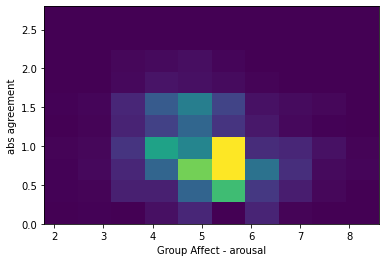

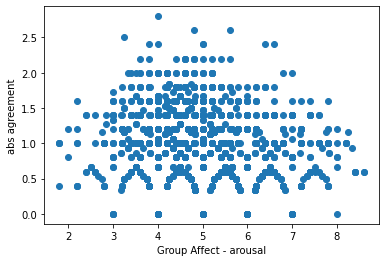

In [31]:
samplewise_aggreement_df = calc_samplewise_agreement_for_MEMO("arousal", mode=metric)

plt.hist2d(samplewise_aggreement_df["arousal"], samplewise_aggreement_df[metric], bins=10)

plt.xlabel("Group Affect - arousal")
plt.ylabel(metric + " agreement")
plt.show()

plt.scatter(samplewise_aggreement_df["arousal"], samplewise_aggreement_df[metric])

plt.xlabel("Group Affect - arousal")
plt.ylabel(metric + " agreement")
plt.show()

In [7]:
samplewise_aggreement_df = calc_samplewise_agreement_for_MEMO("valence", mode=metric)

plt.hist2d(samplewise_aggreement_df["valence"], samplewise_aggreement_df[metric], bins=10)

plt.xlabel("Group Affect - valence")
plt.ylabel(metric + " agreement")
plt.show()

plt.scatter(samplewise_aggreement_df["valence"], samplewise_aggreement_df[metric])

plt.xlabel("Group Affect - valence")
plt.ylabel(metric + " agreement")
plt.show()

NameError: name 'metric' is not defined

In [9]:
temp_labels_df = labels_df.copy()

for grp in groups:
    for ses in sessions:
        if grp+"_"+ses != "8_3":
            interactionID  = grp+'_'+ses
            interaction_df =  temp_labels_df.loc[temp_labels_df['interactionID'] == interactionID] 
            pair_correls, annot_rho_dict, mean_labels, norm_ewe_gt = calc.calculate_goldstandard_gt(interaction_df, "arousal")
    
    print(annot_rho_dict)
    print("Mean: ", mean_labels)
    print("EWE: ", norm_ewe_gt)    
    
    break      

{'Arousal_004': 0.6462447382929727, 'Arousal_001': 0.693123502800838, 'Arousal_002': 0.6290303498980638, 'Arousal_006': 0.6774209189202058, 'Arousal_007': 0.6796928411341413}
Mean:  [4.  3.6 2.8 2.8 3.  5.4 3.  3.2 4.2 4.4 4.4 4.6 3.8 3.4 3.6 4.4 4.  3.8
 4.6 5.2 5.6 6.4 4.6 4.8 5.2 4.4 4.  6.2 5.2 4.2 4.2 4.6 4.4 4.2 4.8 3.8
 4.2 3.4 4.6 3.4 3.4 3.6 3.8 4.2 4.  5.  5.2 5.  3.8 4.6 4.  4.  4.2 4.6
 4.4 4.4 5.  5.2 4.6 4.8 4.4 5.  4.  3.8 5.4 6.4 4.2 5.  4.  3.8 4.4 4.8
 3.8 4.4 4.4 5.6 5.6 4.4 5.4 4.8 4.2 4.  4.4 4.  5.6 4.6 6.2 5.4 4.8 4.8
 5.2 5.4 5.4 4.6 3.6 4.4 4.4 4.6 6.2 5.8 4.2 4.2 4.  3.8 4.  4.  3.6 4.4
 3.6 3.6 3.6 3.2 6.6 5.2 6.4 5.2 7.4 5.2 5.8 5.6 5.4 5.6 5.2 6.4 5.2 4.4
 4.2 5.  4.8 4.8 5.  4.8 4.2 4.6 4.  3.8 3.6 4.8 4.6 4.6 4.2 4.6 6.8 5.8
 7.  7.4 6.2 7.  6.6 6.6 6.8 5.8 5.6 6.4 5.4 5.4 5.  4.8 7.4 7.  6.  6.6
 6.4 4.8 4.2 4.2 4.4 5.4 5.4 6.  5.4 4.8]
EWE:  [3.9706688  3.5726352  2.79111931 2.79111931 2.98027223 5.38302768
 2.98027223 3.18397645 4.18397645 4.40763702 4